<a href="https://colab.research.google.com/github/xaugatp/CreditCardFraudDetection/blob/main/saugat_dle305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CONNECTING TO GOOGLE DRIVE**

In [ ]:

# To mount Google Drive to access files stored in the drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTING NECESSARY LIBRARIES**

In [ ]:
# Importing the necessary libraries
import os
import numpy as np
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
from PIL import Image
import glob
from collections import defaultdict
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam



%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import itertools
import plotly.express as px

**CONNECTING WITH GPU**

In [ ]:

# Check if GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found")

# Check TensorFlow version and GPU details
print("TensorFlow version:", tf.__version__)
print("GPU device:", tf.test.gpu_device_name())

Memory growth enabled for GPU
TensorFlow version: 2.17.0
GPU device: /device:GPU:0


**SETTING THE CONSTANTS**

In [ ]:
IMG_SIZE = (244, 244)  # Resize dimensions for CNN
BATCH_SIZE = 32
IMAGE_FOLDER_PATH_TRAIN = "/content/drive/MyDrive/Saugat_Assessment_2_DLE305/dogs-vs-cats.zip/train"
IMAGE_FOLDER_PATH_TEST = "/content/drive/MyDrive/Saugat_Assessment_2_DLE305/dogs-vs-cats.zip/test1"


**FUNCTIONS FOR LOADINGA AND PREPROCESSING THE DATA**

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path, label=None):
    # Read the image from file
    img = tf.io.read_file(file_path)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize to (224, 224) instead of (244, 244)
    img = tf.image.resize(img, (224, 224))

    img = tf.cast(img, tf.float32) / 255.0  # Normalize image

    # If label is provided, process it
    if label is not None:
        # Adjust label shape to match the model output shape
        label = tf.expand_dims(label, axis=-1)  # Convert shape from (None,) to (None, 1)
        return img, label
    return img

In [ ]:
# Function to create a DataFrame from the dataset folder
def create_image_df(folder_path):
    file_names = os.listdir(folder_path)
    labels = [1 if "dog" in file_name else 0 for file_name in file_names]
    full_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    dataset = pd.DataFrame({'image_path': full_paths, 'target': labels})
    return dataset

In [ ]:
# Loading dataset
IMAGE_FOLDER_PATH_TRAIN = "/content/drive/MyDrive/Saugat_Assessment_2_DLE305/dogs-vs-cats.zip/train"

train_df = create_image_df(IMAGE_FOLDER_PATH_TRAIN)


**FUNCTION TO CREATE TENSORFLOW DATASETS**

In [ ]:

# Function for creating dataset from dataframe
def create_dataset_from_dataframe(df, labeled=True, batch_size=BATCH_SIZE, validation_split=None, subset=None):
    # Check if DataFrame is empty
    if df.empty:
        print("The DataFrame is empty.")
        return None, None, None, None

    # Check for required columns
    if 'image_path' not in df.columns or (labeled and 'target' not in df.columns):
        print("DataFrame missing required columns.")
        return None, None, None, None

    if validation_split is not None:
        # Randomly shuffle and split the data
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        total_size = len(df)
        val_size = int(total_size * validation_split)

        # Create datasets for training and validation
        train_df = df[val_size:]
        val_df = df[:val_size]

        # Generate TensorFlow datasets for train and validation
        train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['target'].values))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['target'].values))

        # Map the preprocessing function and batch the datasets
        train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

        # Cache, shuffle, batch, and prefetch the datasets
        train_dataset = train_dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset, train_df, val_df
    else:
        # If no validation split is provided, return the entire dataset
        dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['target'].values))
        dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset, None, df, None

# Create training and validation datasets with a validation split of 20%
train_dataset, val_dataset, train_df, val_df = create_dataset_from_dataframe(train_df, labeled=True, validation_split=0.2)



**FUNCTIONS FOR CREATING THE VISUALIZATION OF OUR DATSET**

In [ ]:
def plot_data_distribution_after_split(train_df, val_df):
    # Count the number of cats (0) and dogs (1) in both datasets
    train_class_counts = train_df['target'].value_counts()
    val_class_counts = val_df['target'].value_counts()

    # Create a DataFrame for Plotly
    split_df = pd.DataFrame({
        'Class': ['Cat', 'Dog'],
        'Train Count': [train_class_counts[0], train_class_counts[1]],
        'Validation Count': [val_class_counts[0], val_class_counts[1]]
    })

    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Train Count'], name='Train',
                         marker_color='blue'))
    fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Validation Count'], name='Validation',
                         marker_color='red'))

    # Update layout for better presentation
    fig.update_layout(
        title="Class Distribution After Train-Validation Split",
        xaxis_title="Class",
        yaxis_title="Count",
        barmode='group',
        bargap=0.15,
        template="plotly_dark"
    )
    fig.show()
import plotly.express as px

def plot_initial_data_distribution(df):
    # Count the number of cats (0) and dogs (1)
    class_counts = df['target'].value_counts()
    class_labels = ['Cat', 'Dog']

    # Create a DataFrame for Plotly
    distribution_df = pd.DataFrame({
        'Class': class_labels,
        'Count': class_counts
    })

    # Plot using Plotly Express
    fig = px.pie(distribution_df, names='Class', values='Count',
                 title="Initial Data Distribution (Before Train-Validation Split)",
                 color='Class',
                 color_discrete_map={'Cat': 'blue', 'Dog': 'red'})
    fig.show()




In [ ]:
# Function to count the occurrences of each class in the dataset
def count_classes(dataset):
    class_counts = {0: 0, 1: 0}

    # Iterate through the dataset to count labels
    for images, labels in dataset:
        class_counts[0] += np.sum(labels.numpy() == 0)  # Count cats
        class_counts[1] += np.sum(labels.numpy() == 1)  # Count dogs

    return class_counts


# Count classes in train and validation datasets
train_class_counts = count_classes(train_dataset)
val_class_counts = count_classes(val_dataset)

print("Training class counts:", train_class_counts)
print("Validation class counts:", val_class_counts)


# Create DataFrame for plotting
split_df = pd.DataFrame({
    'Class': ['Cat', 'Dog'],
    'Train Count': [train_class_counts[0], train_class_counts[1]],
    'Validation Count': [val_class_counts[0], val_class_counts[1]]
})

# Plot using Plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Train Count'], name='Train', marker_color='blue'))
fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Validation Count'], name='Validation', marker_color='red'))

# Update layout for better presentation
fig.update_layout(
    title="Class Distribution After Train-Validation Split",
    xaxis_title="Class",
    yaxis_title="Count",
    barmode='group',
    bargap=0.15,
    template="plotly_dark"
)
fig.show()

Training class counts: {0: 9986, 1: 10014}
Validation class counts: {0: 2514, 1: 2486}


**VISUALIZING OUR INITIAL TRAIN DATASET**

In [ ]:
# Call the function to display initial distribution
plot_initial_data_distribution(train_df)


**VISUALIZING THE CLASS DISTRIBUTION IN HORIZONTAL BAR**

In [ ]:
# Ensure 'label' column exists in the DataFrame
train_df['label'] = train_df['target'].map({0: 'Cat', 1: 'Dog'})

# Get the count of each class
class_counts = train_df['label'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']  # Rename columns for clarity

# Create a horizontal bar chart
fig = px.bar(
    class_counts,
    x='Count',
    y='Class',
    orientation='h',
    labels={'Count': 'Number of Images', 'Class': 'Category'},
    title='🐶 vs 😺 Class Distribution in Training Data',
    color='Class',
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Customize layout
fig.update_layout(
    xaxis_title='Number of Images',
    yaxis_title='Class',
    showlegend=False,
    height=400,
    bargap=0.4
)

# Show the plot
fig.show()

**VISUALIZING THE DATASET AFTER SPLITTING INTO TRAIN AND VALIDATION SET**

In [ ]:
# Call the function to display distribution after split
plot_data_distribution_after_split(train_df, val_df)

In [ ]:
# Display sample images for Cats and Dogs
def display_sample_images(image_paths, title, rows=4, cols=4):
    fig = plt.figure(figsize=(10,10))
    for i, path in enumerate(image_paths[:rows * cols]):
        img_data = load_and_preprocess_image(path)
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img_data)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



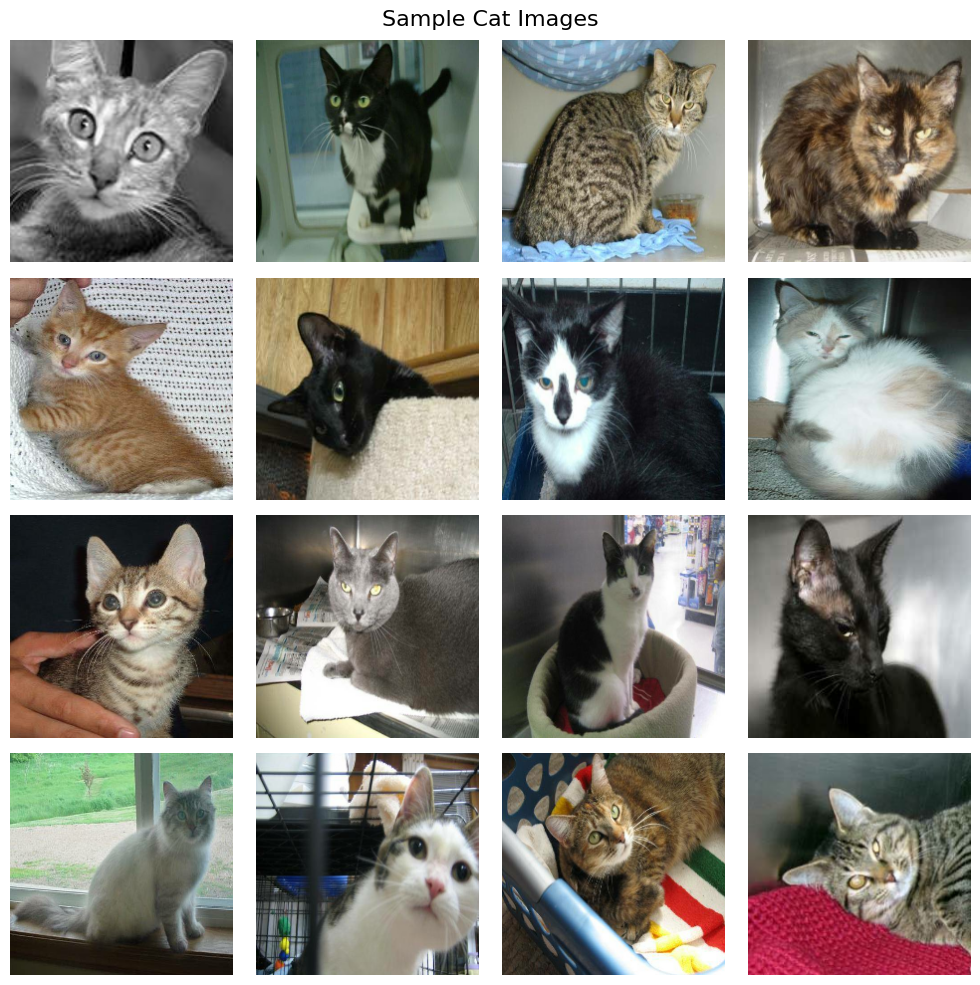

In [ ]:
# Display cat images

display_sample_images(train_df[train_df['target'] == 0]['image_path'].values, "Sample Cat Images")


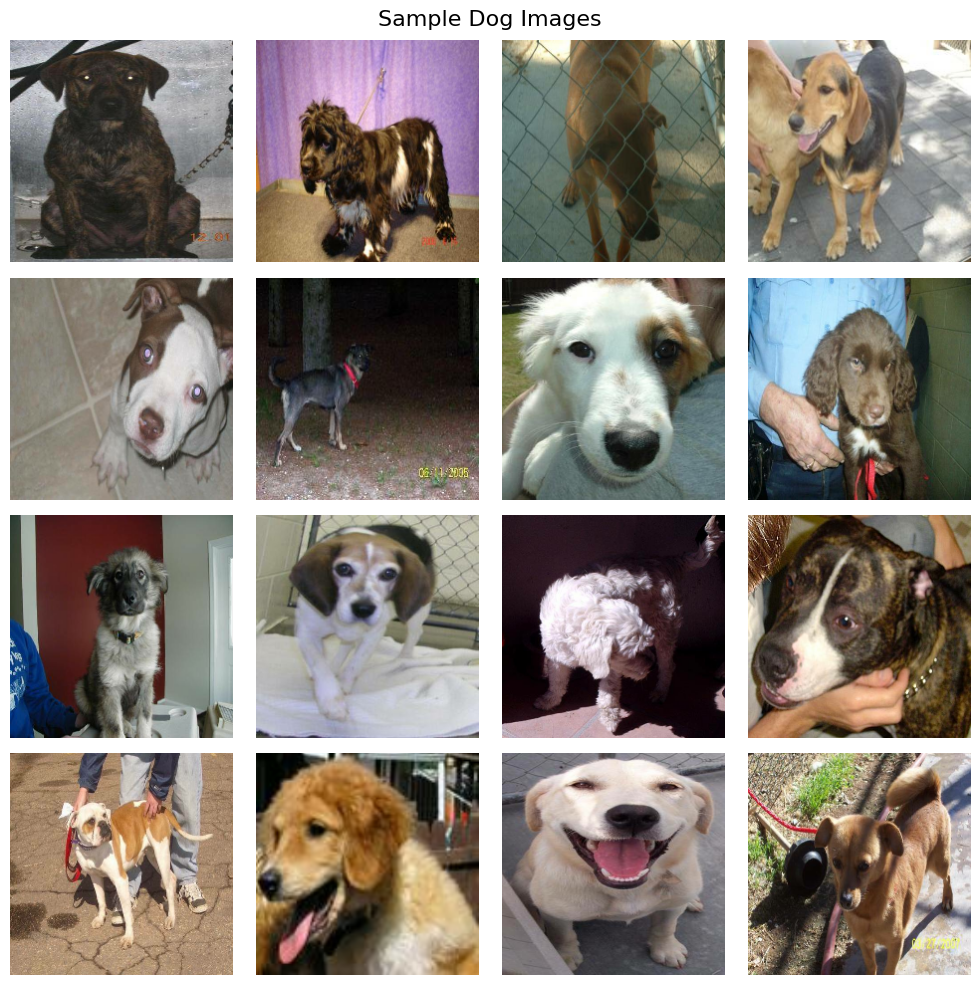

In [ ]:
# Display dog images
display_sample_images(train_df[train_df['target'] == 1]['image_path'].values, "Sample Dog Images")

In [ ]:
# Function to create a dataset for test data without labels
def create_test_dataset(df, batch_size=BATCH_SIZE):
    # Check if DataFrame is empty
    if df.empty:
        print("The test DataFrame is empty.")
        return None

    # Ensure that the DataFrame has the required 'image_path' column
    if 'image_path' not in df.columns:
        print("Test DataFrame missing required column ('image_path').")
        return None

    # Create a TensorFlow dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices(df['image_path'].values)

    # Map the preprocessing function to only load and preprocess images
    dataset = dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch the dataset for efficient loading
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Load test dataset from `test1` folder
test_file_paths = [os.path.join(IMAGE_FOLDER_PATH_TEST, filename) for filename in os.listdir(IMAGE_FOLDER_PATH_TEST)]
test_df = pd.DataFrame({'image_path': test_file_paths})  # No labels in test data

# Create the test dataset}
test_dataset = create_test_dataset(test_df)

# Verify the test dataset
for img_batch in test_dataset.take(1):
    print(f"Test Image batch shape: {img_batch.shape}")


Test Image batch shape: (32, 224, 224, 3)


In [ ]:
# Checking the value counts for train and validation datasets
print("Training Data Value Counts:")
print(train_df['target'].value_counts())

print("\nValidation Data Value Counts:")
print(val_df['target'].value_counts())

# For test data, since there are no labels, just check the number of images
print("\nTest Data Information:")
print(f"Total number of test samples: {len(test_df)}")


Training Data Value Counts:
target
1    10014
0     9986
Name: count, dtype: int64

Validation Data Value Counts:
target
0    2514
1    2486
Name: count, dtype: int64

Test Data Information:
Total number of test samples: 12500


 # **MULTI LAYER PERCEPTRONE**

In [ ]:

# Image size
img_size = (244, 244)
total_pixels = img_size[0] * img_size[1] * 3  # Total pixels for each image (RGB)
fc_size = 512  # Fully connected layer size


In [ ]:
# Define the input layer
inputs = keras.Input(shape=(img_size[0], img_size[1], 3), name='image_input')  # input shape (224, 224, 3)

# Flatten the image input
x = layers.Flatten(name='flattened_img')(inputs)

# First fully connected layer
x = layers.Dense(fc_size, activation='relu', name='first_dense')(x)

# Dropout layer to prevent overfitting (optional, can be adjusted)
x = layers.Dropout(0.5)(x)

# Output layer with sigmoid activation (binary classification: cat vs. dog)
outputs = layers.Dense(1, activation='sigmoid', name='output')(x)

# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Define the optimizer (Adam optimizer with learning rate)
customAdam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="mean_squared_error",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error", "accuracy"])


# Print the model summary to check architecture
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_img (Flatten)              │ (None, 178608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense (Dense)                  │ (None, 512)                 │      91,447,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,448,321 (348.85 MB)

 Trainable params: 91,448,321 (348.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# model training
history = model.fit(
    train_dataset,  # Train data (TensorFlow Dataset)
    epochs=10,  # Number of epochs, adjust as needed
    validation_data=val_dataset,  # Validation data
    batch_size=32,  # Batch size (adjust as needed)
    shuffle=True,  # Shuffle training data to ensure randomness
    verbose=1  # Print training progress
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5062 - binary_crossentropy: 1084.9519 - loss: 0.4907 - mean_squared_error: 0.4907 - val_accuracy: 0.4865 - val_binary_crossentropy: 1835.1594 - val_loss: 0.5135 - val_mean_squared_error: 0.5135
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5026 - binary_crossentropy: 1778.2716 - loss: 0.4974 - mean_squared_error: 0.4974 - val_accuracy: 0.4865 - val_binary_crossentropy: 1835.1594 - val_loss: 0.5135 - val_mean_squared_error: 0.5135
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5009 - binary_crossentropy: 1778.4440 - loss: 0.4991 - mean_squared_error: 0.4991 - val_accuracy: 0.4865 - val_binary_crossentropy: 1835.1594 - val_loss: 0.5135 - val_mean_squared_error: 0.5135
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5067 - binary_crossentropy: 1763.1510 - loss: 0.4933 - mean_squared_error: 0.4933 - val_accuracy: 0.4865 - val_binary_crossentropy: 1835.1594 - va

In [ ]:
# Assuming x_valid and y_valid are your validation data and labels
preds = model.predict(val_dataset)

# Convert the predicted probabilities to binary class predictions (0 or 1)
pred_classes = (preds > 0.5).astype(int).flatten()  # Assuming a binary classification with sigmoid activation


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array
# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes)
recall = recall_score(y_valid, pred_classes)
f1 = f1_score(y_valid, pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4865
Precision: 0.4865
Recall: 1.0000
F1 Score: 0.6546


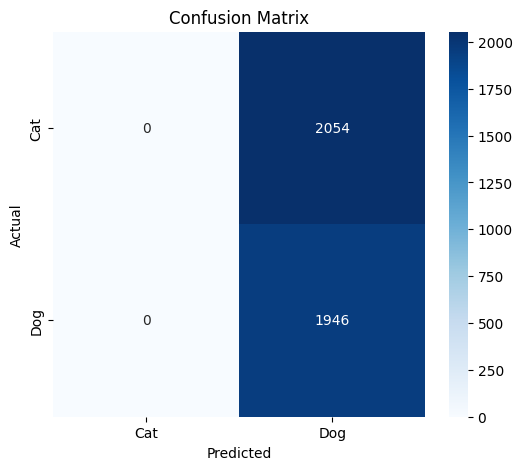

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
import seaborn as sns
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog']))


Classification Report:

              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00      2054
         Dog       0.49      1.00      0.65      1946

    accuracy                           0.49      4000
   macro avg       0.24      0.50      0.33      4000
weighted avg       0.24      0.49      0.32      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



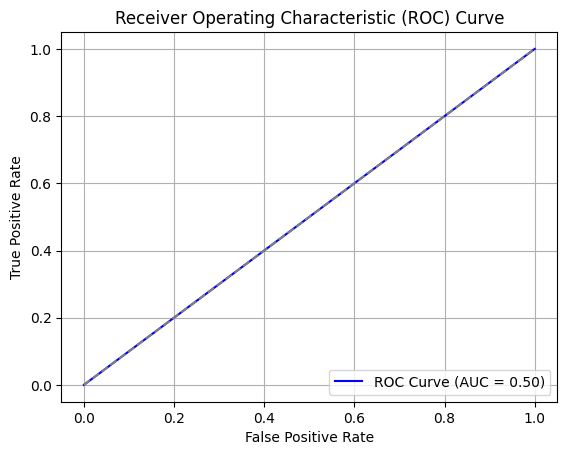

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC (Area Under Curve) score
fpr, tpr, _ = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


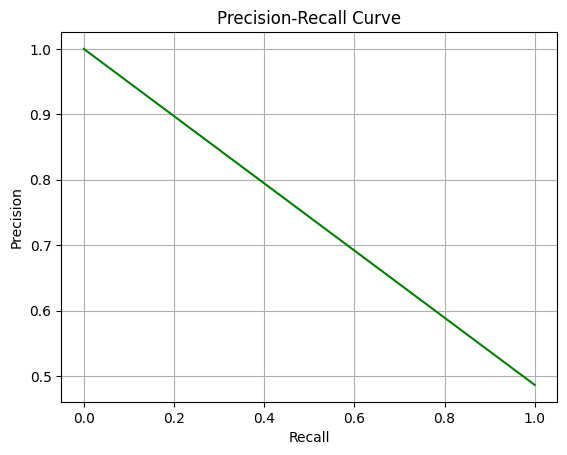

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_valid, preds)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


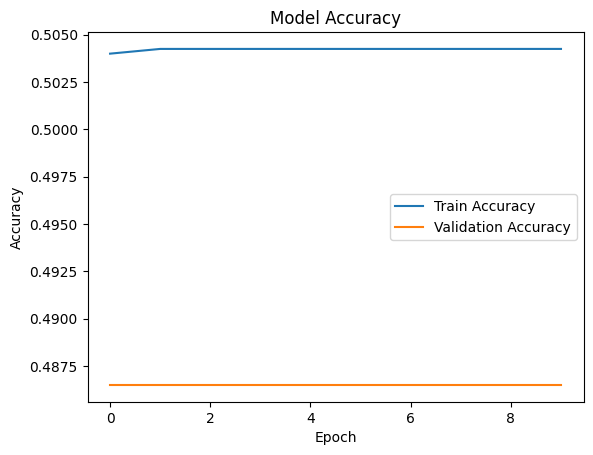

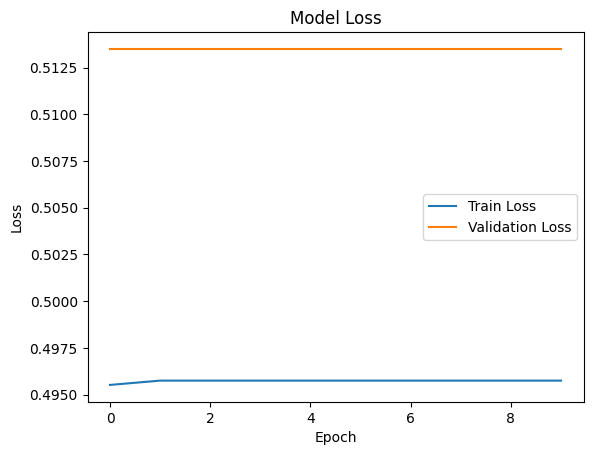

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Single Convolutional Layer**

In [ ]:
# Define the CNN architecture
IMG_SIZE = IMG_SIZE # Example image size
fc_layer_size = 128

# Input layer
conv_inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='image_input')

# Convolutional layer with 24 filters and ReLU activation
conv_layer = layers.Conv2D(24, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Flatten the convolutional output to feed into fully connected layers
conv_x = layers.Flatten(name='flattened_features')(conv_layer)

# Fully connected layers with ReLU activation
conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)

# Output layer with sigmoid activation for binary classification
conv_outputs = layers.Dense(1, activation='sigmoid', name='output')(conv_x)

# Create the model
conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

# Use Adam optimizer
customAdam = Adam(learning_rate=1e-6)  # Small learning rate to prevent overfitting

conv_model.compile(optimizer=customAdam,  # Optimizer
              # Loss function to minimize
              loss="binary_crossentropy",
              # List of metrics to monitor
              metrics=["binary_crossentropy","mean_squared_error", "accuracy"])
# Print model summary
conv_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 242, 242, 24)        │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 121, 121, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_features (Flatten)         │ (None, 351384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 128)                 │      44,977,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,994,593 (171.64 MB)

 Trainable params: 44,994,593 (171.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model with training and validation data
history = conv_model.fit(
    train_dataset,               # Pass train data (x_train, labels_train equivalent)
    epochs=10,                   # Number of epochs, as in the reference code
    batch_size=32,               # Set batch size to manage training speed
    shuffle=True,                # Shuffle the training data for randomness
    validation_data=val_dataset, # Pass validation data (x_valid, labels_valid equivalent)
    verbose=1                    # Print training progress
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6586 - binary_crossentropy: 0.6068 - loss: 0.6068 - mean_squared_error: 0.2103 - val_accuracy: 0.6607 - val_binary_crossentropy: 0.6171 - val_loss: 0.6171 - val_mean_squared_error: 0.2143
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6676 - binary_crossentropy: 0.5960 - loss: 0.5960 - mean_squared_error: 0.2057 - val_accuracy: 0.6425 - val_binary_crossentropy: 0.6188 - val_loss: 0.6188 - val_mean_squared_error: 0.2156
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6848 - binary_crossentropy: 0.5855 - loss: 0.5855 - mean_squared_error: 0.2009 - val_accuracy: 0.6702 - val_binary_crossentropy: 0.6086 - val_loss: 0.6086 - val_mean_squared_error: 0.2107
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6858 - binary_crossentropy: 0.5840 - loss: 0.5840 - mean_squared_error: 0.2004 - val_accuracy: 0.6585 - val_binary_crossentropy: 0.6080 - val_loss: 0.6080 - val_mea

In [ ]:
# Assuming x_valid and y_valid are your validation data and labels
preds = conv_model.predict(val_dataset)

# Convert the predicted probabilities to binary class predictions (0 or 1)
pred_classes = (preds > 0.5).astype(int).flatten()  # Assuming a binary classification with sigmoid activation

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array
# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes)
recall = recall_score(y_valid, pred_classes)
f1 = f1_score(y_valid, pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6763
Precision: 0.6492
Recall: 0.7276
F1 Score: 0.6862


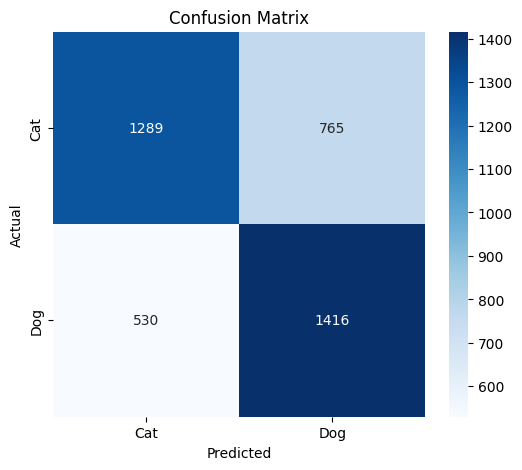

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
import seaborn as sns
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog']))


Classification Report:

              precision    recall  f1-score   support

         Cat       0.71      0.63      0.67      2054
         Dog       0.65      0.73      0.69      1946

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.68      4000
weighted avg       0.68      0.68      0.68      4000



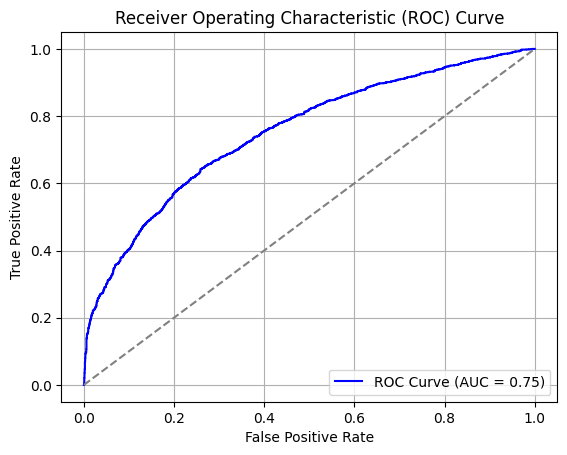

In [ ]:
# Compute ROC curve and AUC (Area Under Curve) score
fpr, tpr, _ = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

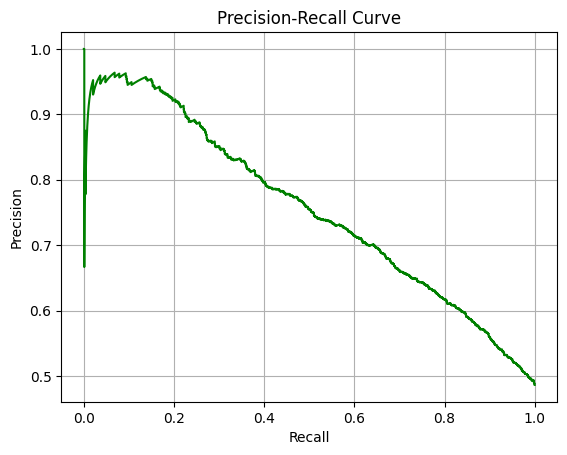

In [ ]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_valid, preds)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

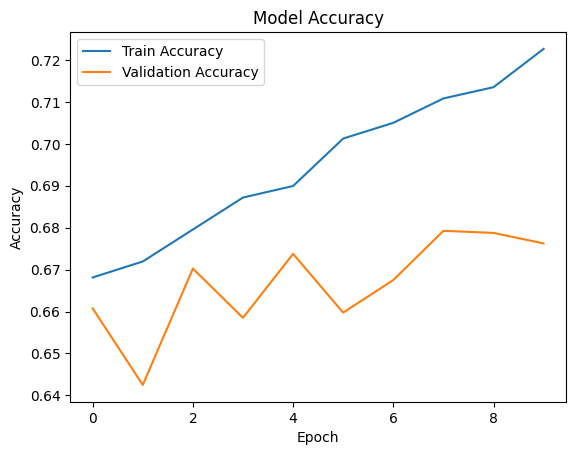

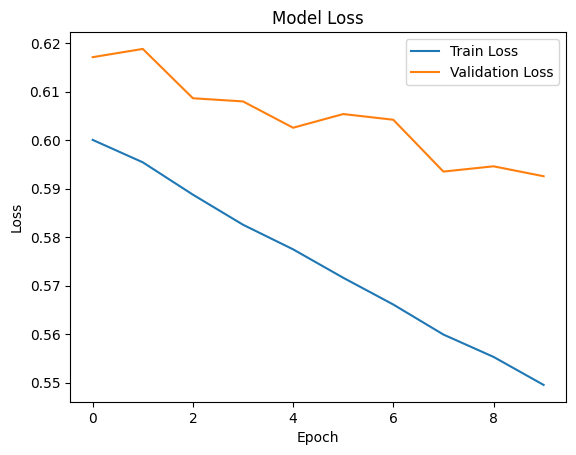

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Neural Network with Two Convolutional Layers**

In [ ]:
# Define constants
fc_layer_size = 256
img_size = IMG_SIZE  # Replace IMG_SIZE with the actual image size (height, width)

In [ ]:
# Build the bigger convolutional model
conv_inputs = keras.Input(shape=(img_size[0], img_size[1], 3), name='ani_image')
conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

conv_layer = layers.Conv2D(48, kernel_size=3, activation='relu')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

conv_x = layers.Flatten(name='flattened_features')(conv_layer)  # Turn image to vector

conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)
conv_outputs = layers.Dense(1, activation='sigmoid', name='class')(conv_x)

conv_model_big = keras.Model(inputs=conv_inputs, outputs=conv_outputs)

# Define the optimizer with a small learning rate
customAdam = keras.optimizers.Adam(learning_rate=1e-6)

# Compile the model
conv_model_big.compile(optimizer=customAdam,  # Optimizer
              loss="binary_crossentropy",  # Loss function
              metrics=["binary_crossentropy", "mean_squared_error", "accuracy"])  # Metrics
conv_model_big.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ani_image (InputLayer)               │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 242, 242, 48)        │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 121, 121, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 119, 119, 48)        │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 59, 59, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_features (Flatten)         │ (None, 167088)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 256)                 │      42,774,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ class (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,862,961 (163.51 MB)

 Trainable params: 42,862,961 (163.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit model on training data
print('# Fit model on training data')
history = conv_model_big.fit(train_dataset,
                         batch_size=32,
                         shuffle=True,
                         epochs=15,
                         validation_data=val_dataset,
                         verbose=1)

# Fit model on training data
Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.5503 - binary_crossentropy: 0.6862 - loss: 0.6862 - mean_squared_error: 0.2465 - val_accuracy: 0.6030 - val_binary_crossentropy: 0.6679 - val_loss: 0.6679 - val_mean_squared_error: 0.2375
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.6043 - binary_crossentropy: 0.6630 - loss: 0.6630 - mean_squared_error: 0.2352 - val_accuracy: 0.6135 - val_binary_crossentropy: 0.6542 - val_loss: 0.6542 - val_mean_squared_error: 0.2311
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.6305 - binary_crossentropy: 0.6455 - loss: 0.6455 - mean_squared_error: 0.2270 - val_accuracy: 0.6195 - val_binary_crossentropy: 0.6447 - val_loss: 0.6447 - val_mean_squared_error: 0.2267
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.6458 - binary_crossentropy: 0.6316 - loss: 0.6316 - mean_squared_error: 0.2206 - val_accuracy: 0.6392 - val_binary_crossentropy: 0.6328

In [ ]:
# Assuming x_valid and y_valid are your validation data and labels
preds = conv_model_big.predict(val_dataset)

# Convert the predicted probabilities to binary class predictions (0 or 1)
pred_classes = (preds > 0.5).astype(int).flatten()  # Assuming a binary classification with sigmoid activation

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array
# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes)
recall = recall_score(y_valid, pred_classes)
f1 = f1_score(y_valid, pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7047
Precision: 0.6713
Recall: 0.7703
F1 Score: 0.7174


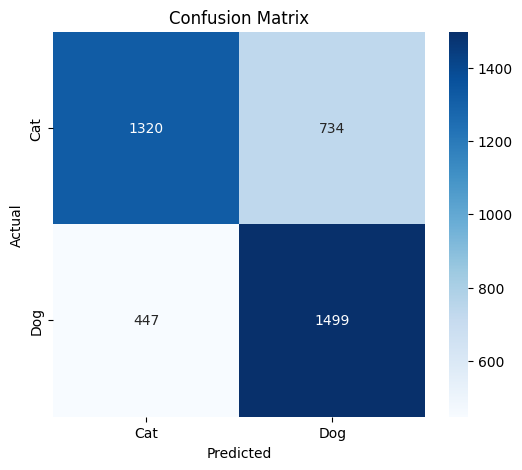

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
import seaborn as sns
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog']))

Classification Report:

              precision    recall  f1-score   support

         Cat       0.75      0.64      0.69      2054
         Dog       0.67      0.77      0.72      1946

    accuracy                           0.70      4000
   macro avg       0.71      0.71      0.70      4000
weighted avg       0.71      0.70      0.70      4000



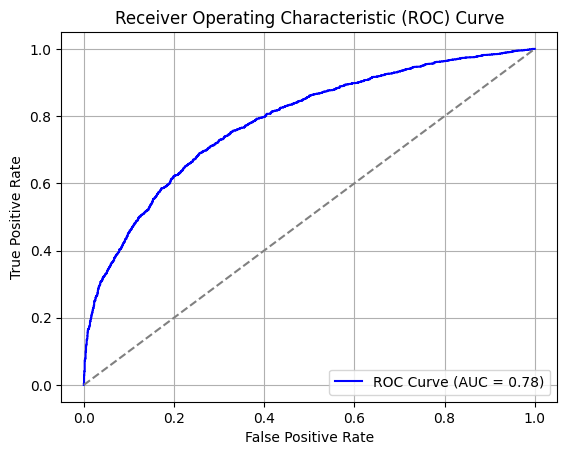

In [ ]:
# Compute ROC curve and AUC (Area Under Curve) score
fpr, tpr, _ = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

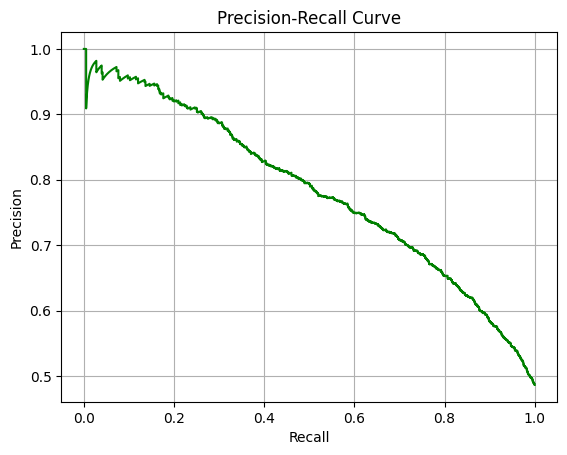

In [ ]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_valid, preds)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

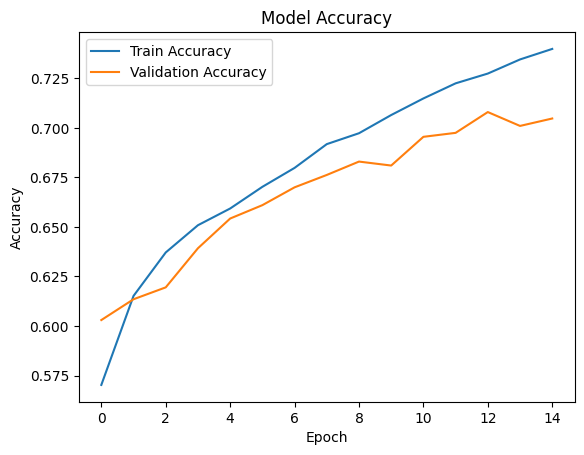

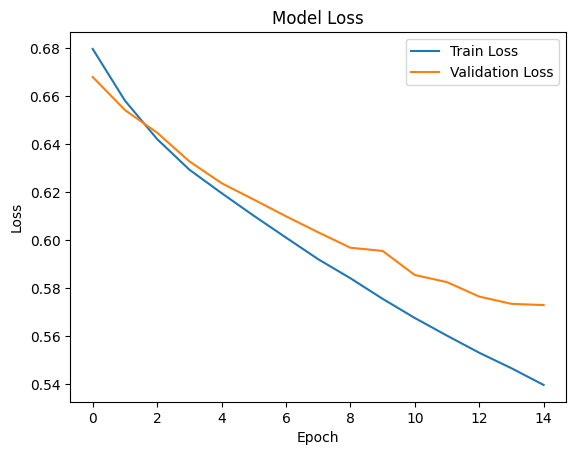

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Huge Modal**

In [ ]:
from tensorflow.keras import layers, optimizers
# Define a larger CNN model
def create_huge_cnn_model(input_shape=(244, 244, 3), fc_layer_size=256):
    conv_inputs = keras.Input(shape=input_shape, name='input_image')

    # Add multiple Conv2D + MaxPooling layers for deeper feature extraction
    conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_inputs)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    # Flatten the output to feed into fully connected layers
    conv_x = layers.Flatten()(conv_layer)

    # Add dense layers for classification
    conv_x = layers.Dense(fc_layer_size, activation='relu')(conv_x)
    conv_x = layers.Dropout(0.5)(conv_x)
    conv_x = layers.Dense(fc_layer_size, activation='relu')(conv_x)
    conv_x = layers.Dropout(0.5)(conv_x)

    # Output layer with sigmoid activation for binary classification
    conv_outputs = layers.Dense(1, activation='sigmoid')(conv_x)

    # Compile the model
    huge_conv_model = keras.Model(inputs=conv_inputs, outputs=conv_outputs)
    customAdam = optimizers.Adam(learning_rate=1e-4)
    huge_conv_model.compile(
        optimizer=customAdam,
        loss='binary_crossentropy',
        metrics=['accuracy', 'binary_crossentropy']
    )

    return huge_conv_model

# Instantiate the model
huge_model = create_huge_cnn_model()

# Summary of the model
huge_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 244, 244, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705,409 (33.21 MB)

 Trainable params: 8,705,409 (33.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the model using your train_dataset and val_dataset
EPOCHS = 10
history = huge_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    batch_size=32,
    shuffle=True,
    verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 227ms/step - accuracy: 0.5380 - binary_crossentropy: 0.6852 - loss: 0.6852 - val_accuracy: 0.6938 - val_binary_crossentropy: 0.5744 - val_loss: 0.5744
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.7166 - binary_crossentropy: 0.5591 - loss: 0.5591 - val_accuracy: 0.7848 - val_binary_crossentropy: 0.4656 - val_loss: 0.4656
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 212ms/step - accuracy: 0.7865 - binary_crossentropy: 0.4586 - loss: 0.4586 - val_accuracy: 0.8292 - val_binary_crossentropy: 0.3698 - val_loss: 0.3698
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 212ms/step - accuracy: 0.8452 - binary_crossentropy: 0.3633 - loss: 0.3633 - val_accuracy: 0.8684 - val_binary_crossentropy: 0.3087 - val_loss: 0.3087
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.8827 - binary_crossentropy: 0.2862 - loss: 0.2862 - val_accuracy: 0.8854 - val_binary_crossentropy: 0.2865 - val_loss: 0.2865
Epoch 6/10
625/625 ━

In [ ]:
# Assuming x_valid and y_valid are your validation data and labels
preds = huge_model.predict(val_dataset)

# Convert the predicted probabilities to binary class predictions (0 or 1)
pred_classes = (preds > 0.5).astype(int).flatten()  # Assuming a binary classification with sigmoid activation

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array
# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes)
recall = recall_score(y_valid, pred_classes)
f1 = f1_score(y_valid, pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9300
Precision: 0.9225
Recall: 0.9381
F1 Score: 0.9302


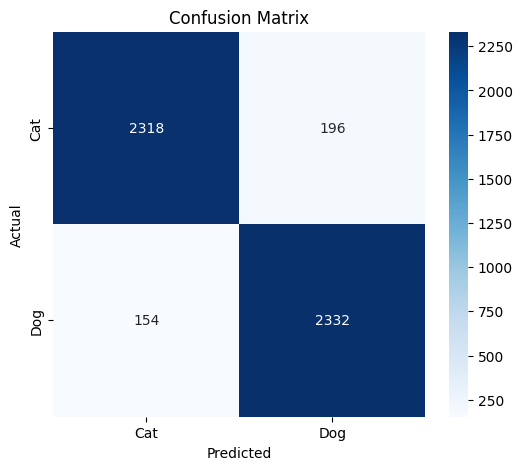

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
import seaborn as sns
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog']))

Classification Report:

              precision    recall  f1-score   support

         Cat       0.94      0.92      0.93      2514
         Dog       0.92      0.94      0.93      2486

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



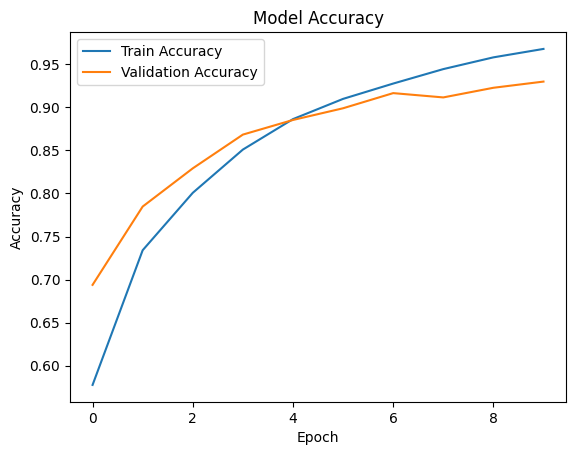

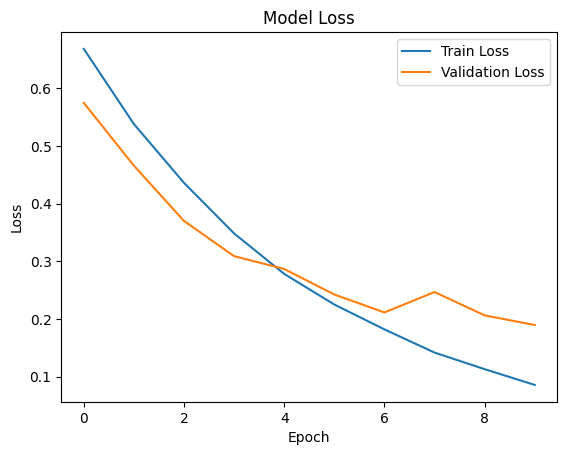

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**VGG LIKE MODEL**



In [ ]:
from tensorflow.keras import layers, models
# Define the input layer (adjust the shape according to your image dimensions)
input_shape = (224, 224, 3)  # For example, if your images are 224x224 RGB
# Define constants
fc_layer_size = 256
img_size = IMG_SIZE
conv_inputs = keras.Input(shape=input_shape, name='input_image')
# First convolutional block
conv_layer = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv_inputs)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)


# Second convolutional block
conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)  # Batch Normalization
conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Third convolutional block
conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)  # Batch Normalization
conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Fourth convolutional block
conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)  # Batch Normalization
conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Flatten the output
flattened = layers.Flatten()(conv_layer)

# Fully connected layers with Dropout
fc_layer = layers.Dense(fc_layer_size, activation='relu')(flattened)
fc_layer = layers.Dropout(0.5)(fc_layer)  # Dropout with 50% rate
fc_layer = layers.Dense(fc_layer_size, activation='relu')(fc_layer)

# Output layer
output = layers.Dense(1, activation='sigmoid')(fc_layer)

# Create the model
vgg_model = models.Model(inputs=conv_inputs, outputs=output)

# Compile the model
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
                  loss='binary_crossentropy',
                  metrics=["binary_crossentropy","mean_squared_error", "accuracy"])

# Show the model summary
vgg_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 30,445,633 (116.14 MB)

 Trainable params: 30,443,713 (116.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:

# Fit model on training data
print('# Fit model on training data')
history = vgg_model.fit(train_dataset,
                         batch_size=32,
                         shuffle=True,
                         epochs=15,
                         validation_data=val_dataset,
                         verbose=1)

# Fit model on training data
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 439ms/step - accuracy: 0.5885 - binary_crossentropy: 1.0157 - loss: 1.0157 - mean_squared_error: 0.2712 - val_accuracy: 0.7046 - val_binary_crossentropy: 0.6091 - val_loss: 0.6091 - val_mean_squared_error: 0.2099
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 255s 408ms/step - accuracy: 0.6917 - binary_crossentropy: 0.5618 - loss: 0.5618 - mean_squared_error: 0.1908 - val_accuracy: 0.7178 - val_binary_crossentropy: 0.5393 - val_loss: 0.5393 - val_mean_squared_error: 0.1811
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 409ms/step - accuracy: 0.7477 - binary_crossentropy: 0.4937 - loss: 0.4937 - mean_squared_error: 0.1641 - val_accuracy: 0.7966 - val_binary_crossentropy: 0.4302 - val_loss: 0.4302 - val_mean_squared_error: 0.1375
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 410ms/step - accuracy: 0.8149 - binary_crossentropy: 0.3942 - loss: 0.3942 - mean_squared_error: 0.1270 - val_accuracy: 0.8692 - val_binary_crossentropy

In [ ]:
# Assuming x_valid and y_valid are your validation data and labels
preds = vgg_model.predict(val_dataset)

# Convert the predicted probabilities to binary class predictions (0 or 1)
pred_classes = (preds > 0.5).astype(int).flatten()  # Assuming a binary classification with sigmoid activation

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array
# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes)
recall = recall_score(y_valid, pred_classes)
f1 = f1_score(y_valid, pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9422
Precision: 0.9511
Recall: 0.9316
F1 Score: 0.9413


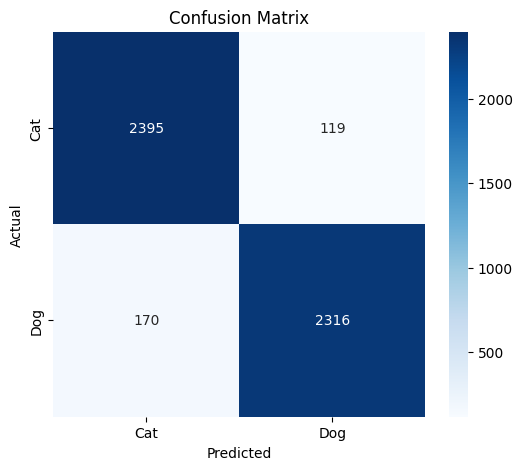

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
import seaborn as sns
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog']))

Classification Report:

              precision    recall  f1-score   support

         Cat       0.93      0.95      0.94      2514
         Dog       0.95      0.93      0.94      2486

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



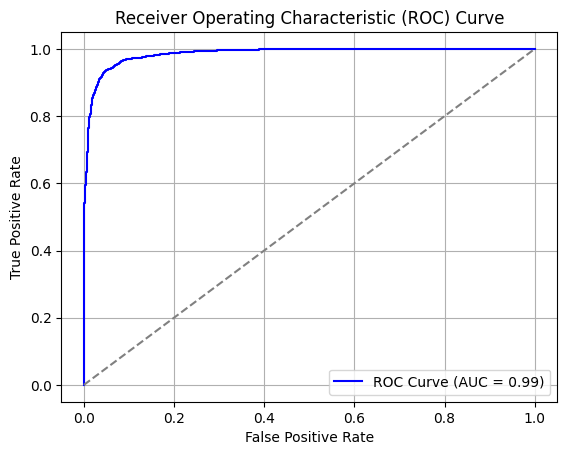

In [ ]:
# Compute ROC curve and AUC (Area Under Curve) score
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

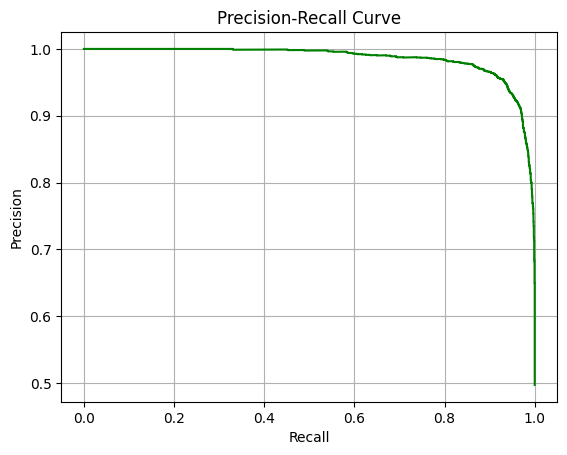

In [ ]:
# Compute precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_valid, preds)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

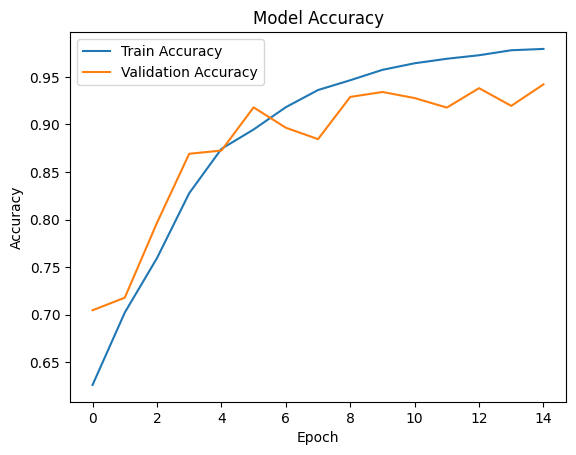

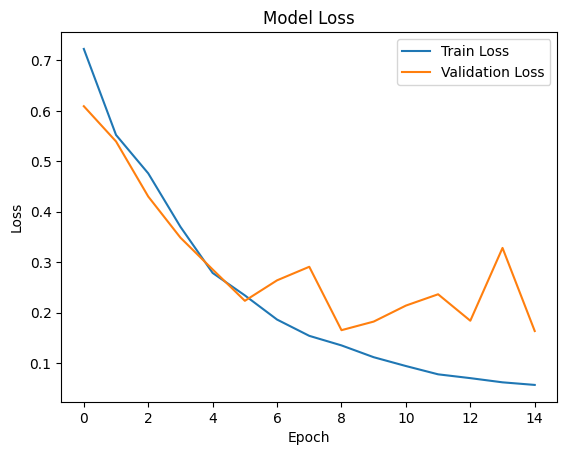

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

After experimenting with all models vgg performed well so we will experiment with our test data if it can do the prediction correctly of not.
Now we will use the model on our test dataset and see how well it can predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-41-8a4624061f57>:19: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


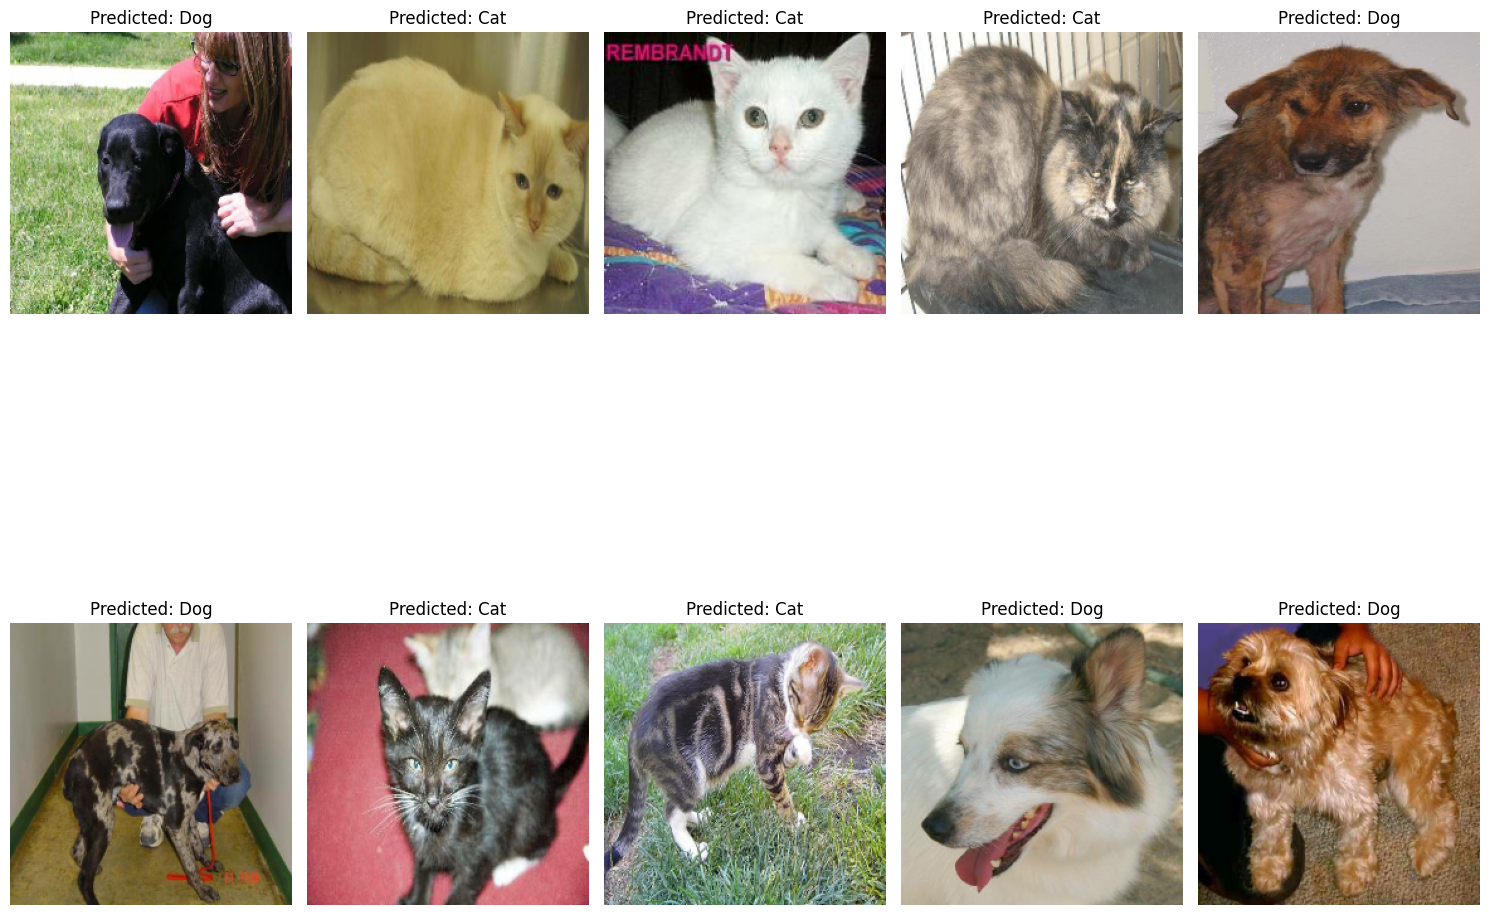

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, test_dataset, class_labels=['Cat', 'Dog'], num_samples=10):
    # Initialize lists to store images and predictions
    images, predictions = [], []
    count = 0

    # Collect images and make predictions until we reach the desired number of samples
    for img_batch in test_dataset:
        for img in img_batch:
            if count >= num_samples:
                break
            # Convert the image tensor to a NumPy array
            images.append(img.numpy())
            # Prepare the image for the model
            img_array = np.expand_dims(img.numpy(), axis=0)  # Expand dimensions to match the input shape
            # Make a prediction
            prediction = model.predict(img_array)
            # Map the prediction to the corresponding class label
            predicted_label = class_labels[int(np.round(prediction[0]))]  # Assuming binary classification
            predictions.append(predicted_label)
            count += 1
        if count >= num_samples:
            break

    # Visualize the images with their predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Testing the function
visualize_predictions(vgg_model, test_dataset, num_samples=10)